In [9]:
!pip install category_encoders

!pip install catboost

# prompt: Read the data from file '/content/sample_data/car-data-category-encoding.xlsx' in a dataframe named carEnc and print the dataframe carEnc.
# create separate function each for doing 'Integer or Ordinal encoding', 'One-hot encoding', 'Binary encoding', 'Target encoding', 'Frequency encoding' which takes the dataframe carEnc and target column and returns a new dataframe with all columns encoded except the target column and then print the each returned dataframe

import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier  # Importing RandomForestClassifier
from sklearn.metrics import classification_report # Importing classification_report


# Load the data
carEnc = pd.read_excel('/content/sample_data/car-data-category-encoding.xlsx')

# Print the original dataframe
#print("Original DataFrame:")
#print(carEnc)

# Separate features and target
carEncWithoutTarget = carEnc.drop("class", axis=1)
carEncOnlyTarget = carEnc["class"]

def integer_or_ordinal_encoding(df, target_column):
    df_encoded = df.copy()
    for col in df.columns:
        if col != target_column and df[col].dtype == 'object':
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col])
    return df_encoded


def one_hot_encoding(df, target_column):
    df_encoded = df.copy()
    for col in df.columns:
        if col != target_column and df[col].dtype == 'object':
            ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            encoded_data = ohe.fit_transform(df_encoded[[col]])
            encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out([col]))
            df_encoded = df_encoded.drop(col, axis=1)
            df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    return df_encoded


def binary_encoding(df, target_column):
    df_encoded = df.copy()
    for col in df.columns:
        if col != target_column and df[col].dtype == 'object':
            be = ce.BinaryEncoder(cols=[col])
            df_encoded = be.fit_transform(df_encoded)
    return df_encoded


def target_encoding(df, target_column):
    df_encoded = df.copy()
    for col in df.columns:
        if col != target_column and df[col].dtype == 'object':
            te = ce.TargetEncoder(cols=[col])
            df_encoded = te.fit_transform(df_encoded, df_encoded[target_column])
    return df_encoded


def frequency_encoding(df, target_column):
    df_encoded = df.copy()
    for col in df.columns:
        if col != target_column and df[col].dtype == 'object':
            frequency_map = df[col].value_counts(normalize=True).to_dict()
            df_encoded[col] = df_encoded[col].map(frequency_map)
    return df_encoded

# Example usage (replace 'target_column' with your actual target column name)
target_col = 'target'

# Encoding and printing
#print("\nInteger/Ordinal Encoding:")
int_encoded = integer_or_ordinal_encoding(carEnc, "class")
#print(int_encoded)

#print("\nOne-Hot Encoding:")
onehot_encoded = one_hot_encoding(carEnc, "class")
#print(onehot_encoded)

#print("\nBinary Encoding:")
binary_encoded = binary_encoding(carEnc, "class")
#print(binary_encoded)

#print("\nTarget Encoding:")
target_encoded = target_encoding(carEnc, "class")
#print(target_encoded)

#print("\nFrequency Encoding:")
freq_encoded = frequency_encoding(carEnc, "class")
freq_encoded

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(carEncWithoutTarget, carEncOnlyTarget, test_size=0.2, random_state=42, stratify=carEncOnlyTarget)
#print("-------------------------------------------------------------------------------------------------")
#print("X_train",X_train)
#print("X_test",X_test)
#print("y_train",y_train)
#print("y_test",y_test)

model = CatBoostClassifier(verbose=0)
model.fit(X_train, y_train, cat_features=X_train.columns.tolist())
y_pred = model.predict(X_test)

# Apply integer/ordinal encoding to X_train and X_test
X_train_encoded = integer_or_ordinal_encoding(X_train, "class")  # Encoding X_train
X_test_encoded = integer_or_ordinal_encoding(X_test, "class")    # Encoding X_test

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)

report


'              precision    recall  f1-score   support\n\n         acc       0.97      0.95      0.96        77\n        good       0.93      0.93      0.93        14\n       unacc       0.99      1.00      0.99       242\n       vgood       1.00      0.92      0.96        13\n\n    accuracy                           0.98       346\n   macro avg       0.97      0.95      0.96       346\nweighted avg       0.98      0.98      0.98       346\n'

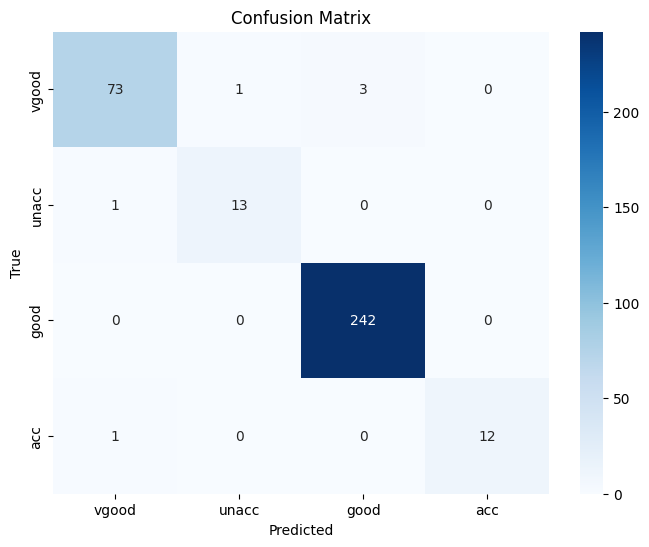

In [10]:
# prompt: print the confusion matrix for above classification report

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from the previous code
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(set(y_test)), yticklabels=list(set(y_test)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
